In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee

# The Gelman-Rubin statistic and `emcee`

In this post, I'll give a simple demo of using the Gelman-Rubin statistic (see [this paper for an overview and alternatives](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/BrooksGelman.pdf) to quantify convergance when using the [`emcee`](http://dan.iel.fm/emcee/current/) software package. There are issues with this approach which remain to be addressed. The Gelman-Rubin statistic applies to cases where one runs multiple independent MCMC simulations. `emcee` uses an ensemble sampler: `n` parallel *walkers* are run and when jumping, the position of the other walkers is used to generate proposal stes (for details, you may want to read [this](http://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-p.pdf)). As such, the `n` walkers are certainly not independent. I won't go into details of the issues this may cause here as I've not yet investigated it fully, but instead I will simply implement it naively and see if it works. 

The initial setup of the problem follows [this post](http://ga7g08.github.io/2015/01/20/Searching-for-signals-in-noise/) with some minor modifications.

## Data
First, we generate some fake data to which we will fit a model;

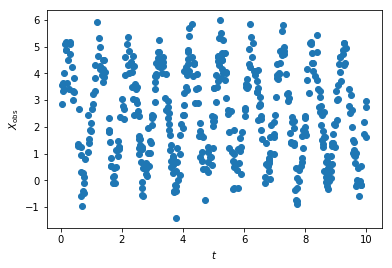

In [2]:
# Model parameters
A = 2.3
f = 1
X0 = 2.5

# Noise parameter
sigma = 0.6

N = 500
t = np.sort(np.random.uniform(0, 10, N))
X = X0 + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, sigma, N)

plt.plot(t, X, "o")
plt.xlabel("$t$")
plt.ylabel(r"$X_{\mathrm{obs}}$")
plt.show()

## Set-up for using `emcee`

### Define some generic helper functions

In [3]:
def Generic_lnuniformprior(theta, theta_lims):
    """ Generic uniform priors on theta 
    
    Parameters
    ----------
    theta : array_like 
        Value of the parameters
    theta_lims: array_like of shape (len(theta), 2)
        Array of pairs [min, max] for each theta paramater
        
    """
    
    theta_lims = np.array(theta_lims)
    
    if all(theta - theta_lims[:, 0] > 0 ) and all(theta_lims[:, 1] - theta > 0):
        return np.prod(1.0/np.diff(theta_lims, axis=1))
    return -np.inf

def Generic_lnlike(theta, t, x, model):
    """ Generic likelihood function for signal in Gaussian noise
    
    Parameters
    ----------
    theta : array_like
        Value of the parameters, the noise strength `sigma` should ALWAYS be
        the last element in the list
    t : array_like
        The independant variable
    x : array_like
        The observed dependent variable
    model : func
        Signal model, calling `model(theta[:-1], t)` should
        produced the corresponding value of the signal 
        alone `x_val`, without noise. 
    
    """
    
    sigma2 = theta[-1]**2
    return -0.5*(np.sum((x-model(theta[:-1], t))**2 / sigma2 + np.log(2*np.pi*sigma2)))   
    
def PlotWalkers(sampler, symbols=None, alpha=0.4, color="k", PSRF=None, PSRFx=None):
    """ Plot all the chains from a sampler """
    nwalkers, nsteps, ndim = sampler.chain.shape

    fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 9))

    for i in range(ndim):
        axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=alpha)
        if symbols:
            axes[i].set_ylabel(symbols[i])
        if PSRF is not None:
            PSRF = np.array(PSRF)
            PSRFx = np.array(PSRFx)
            ax = axes[i].twinx()
            idx = np.argmin(np.abs(PSRF[:, i] - 1.1))
            ax.plot(PSRFx[:idx+1], PSRF[:idx+1, i], '-r')
            ax.plot(PSRFx[idx:], PSRF[idx:, i], '--r')    

### Define model and uniform prior

In [23]:
def model(theta, t):
    A, f, X0 = theta 
    return X0 + A * np.sin(2 * np.pi * f * t)
    
lnlike = lambda theta, x, y: Generic_lnlike(theta, x, y, model)       

# Tie the two together
def lnprob(theta, x, y):
    """ Generic function ties together the lnprior and lnlike """ 
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)
            
# Prior
theta_lims = [[-100, 200], 
              [0.95, 1.05], 
              [0.0, 100.0],
              [0.1, 1.3]
              ]
lnprior = lambda theta: Generic_lnuniformprior(theta, theta_lims) 

## Calculating the PSRF

Here, I follow the description on [this blog](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) for how to calculate the Potential Scale Reduction Factor (PSRF), a measure of the converegance. For PSRF < 1.2, Gelman & Rubin state the the chains have converged.

In practical terms, the sampler is run for a number of steps, the PSRF is calculated, and then the sampler is run again. Here I simply plot how this changes for each parameter. This becomes practically useful when some measuure of the convergence (say for example the maximum PSRF) is used to end a run prematurely (before the maximum number of steps). 

First, here is a convienience function which computes the PSRF:

In [12]:
def get_convergence_statistic(i, sampler, nwalkers, convergence_length=10,
                              convergence_period=10):
    s = sampler.chain[:, i-convergence_length+1:i+1, :]
    within_std = np.mean(np.var(s, axis=1), axis=0)
    per_walker_mean = np.mean(s, axis=1)
    mean = np.mean(per_walker_mean, axis=0)
    between_std = np.sqrt(np.mean((per_walker_mean-mean)**2, axis=0))
    W = within_std
    B_over_n = between_std**2 / convergence_period
    Vhat = ((convergence_period-1.)/convergence_period * W
            + B_over_n + B_over_n / float(nwalkers))
    c = Vhat/W
    return i - convergence_period/2, c

Okay, now here is an example

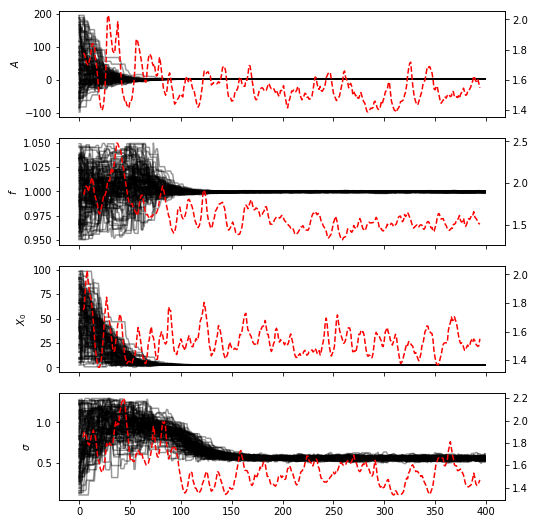

In [29]:
ndim = 4
nwalkers = 100
nsteps = 400
# Initialise the walkers
walker_pos = [[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
                                                        for i in range(nwalkers)] 

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, X))

PSRF = []
PSRFx = []
for i, output in enumerate(sampler.sample(walker_pos, iterations=nsteps)):
    idx, c = get_convergence_statistic(i, sampler, nwalkers, 
                                       convergence_length=10, convergence_period=10)
    PSRF.append(c)
    PSRFx.append(idx)
  
symbols = ["$A$", "$f$", "$X_{0}$", "$\sigma$"]            
PlotWalkers(sampler, symbols=symbols, PSRF=PSRF, PSRFx=PSRFx)
plt.show()

The reality is that the `convergence_period` and `convergence_length` may need to be fine-tuned. And one has to decide how to intepret the four convergence tests. From simple experimentation, if the length is too long, the test provides evidence for convergence when visual inspection indicates they have not converged. It is likely this is because the Gelam & Rubin sta